In [3]:
import numpy as np
import pandas as pd
# Mining: 
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import colorsys

In [4]:
df = pd.read_csv("../01_artwork_clustering/omniart-post-artwork-clustering.csv")

In [5]:
artwork_clusters = pd.read_csv("../01_artwork_clustering/artwork-centroids.csv")

**1. Frequent itemset mining**

In [6]:
total_transactions = len(df)
total_transactions

264218

In [7]:
min_support = 0.0005 # 0.5% -> 0.0005*264218 = 132 transactions

In [8]:
min_lift = 5 # 5x more likely to be related

In [9]:
def get_freq_itemset(df, dims, min_support):
    mining_df = df.copy()
    mining_df["cluster"] = "cluster_" + mining_df["cluster"].astype(str)
    for dim in dims:
        mining_df[f"{dim}"] = f"{dim}_" + mining_df[f"{dim}"].astype(str)

    # One-Hot Encode
    df_encoded = pd.get_dummies(mining_df, prefix="", prefix_sep="")
    df_encoded = df_encoded.astype(bool)
    
    # Frequent Itemsets with FP-Growth
    freq_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

    return freq_itemsets

In [10]:
mining_df = df[["cluster", "decade"]]

In [11]:
freq_itemset = get_freq_itemset(mining_df, ["decade"], min_support=0.0001)

In [12]:
freq_itemset

,support,itemsets
0,0.174629,(decade_2000)
1,0.011309,(cluster_36)
2,0.014897,(cluster_81)
3,0.001283,(decade_1360)
4,0.004837,(cluster_33)
...,...,...
1263,0.000159,"(decade_1580, cluster_24)"
1264,0.000375,"(cluster_68, decade_2000)"
1265,0.001306,"(cluster_68, decade_2010)"
1266,0.000106,"(cluster_1, decade_1320)"


In [13]:
# Helper function: extract string from frozenset
def get_item_str(f_set):
    if isinstance(f_set, frozenset) and len(f_set) == 1: return list(f_set)[0]
    return None

In [14]:
multi_item_freq_itemset = freq_itemset[freq_itemset['itemsets'].apply(len) > 1]
multi_item_freq_itemset.to_csv('decade-freq-itemsets''.csv', index=False)

**2. Association rules**

In [15]:
def get_association_rules(freq_itemsets, min_threshold, metric="lift"):
    rules = association_rules(freq_itemsets, metric=metric, min_threshold=min_threshold)
    return rules.sort_values(by="lift", ascending=False)

In [16]:
rules = get_association_rules(freq_itemset, min_threshold=min_lift)

In [17]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
65,(cluster_82),(decade_1680),0.014234,0.001260,0.000148,0.010370,8.227719,1.0,0.000130,1.009205,0.891145,0.009618,0.009121,0.063743
64,(decade_1680),(cluster_82),0.001260,0.014234,0.000148,0.117117,8.227719,1.0,0.000130,1.116530,0.879568,0.009618,0.104368,0.063743
31,(cluster_82),(decade_1650),0.014234,0.007653,0.000799,0.056102,7.330952,1.0,0.000690,1.051329,0.876062,0.037868,0.048823,0.080227
30,(decade_1650),(cluster_82),0.007653,0.014234,0.000799,0.104352,7.330952,1.0,0.000690,1.100617,0.870252,0.037868,0.091419,0.080227
24,(decade_1600),(cluster_8),0.003289,0.008122,0.000189,0.057537,7.084071,1.0,0.000163,1.052432,0.861672,0.016863,0.049820,0.040418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,(cluster_24),(decade_1530),0.015465,0.002865,0.000223,0.014440,5.039880,1.0,0.000179,1.011744,0.814173,0.012333,0.011608,0.046189
55,(decade_1770),(cluster_71),0.003387,0.016418,0.000280,0.082682,5.035951,1.0,0.000224,1.072236,0.804152,0.014344,0.067369,0.049870
54,(cluster_71),(decade_1770),0.016418,0.003387,0.000280,0.017059,5.035951,1.0,0.000224,1.013908,0.814805,0.014344,0.013718,0.049870
34,(cluster_24),(decade_1620),0.015465,0.008603,0.000670,0.043319,5.035445,1.0,0.000537,1.036288,0.813996,0.028632,0.035017,0.060595


In [18]:
rules.to_csv("decade-rules.csv", index=False)

**3. Analysis**

**3.1. Associations quality**

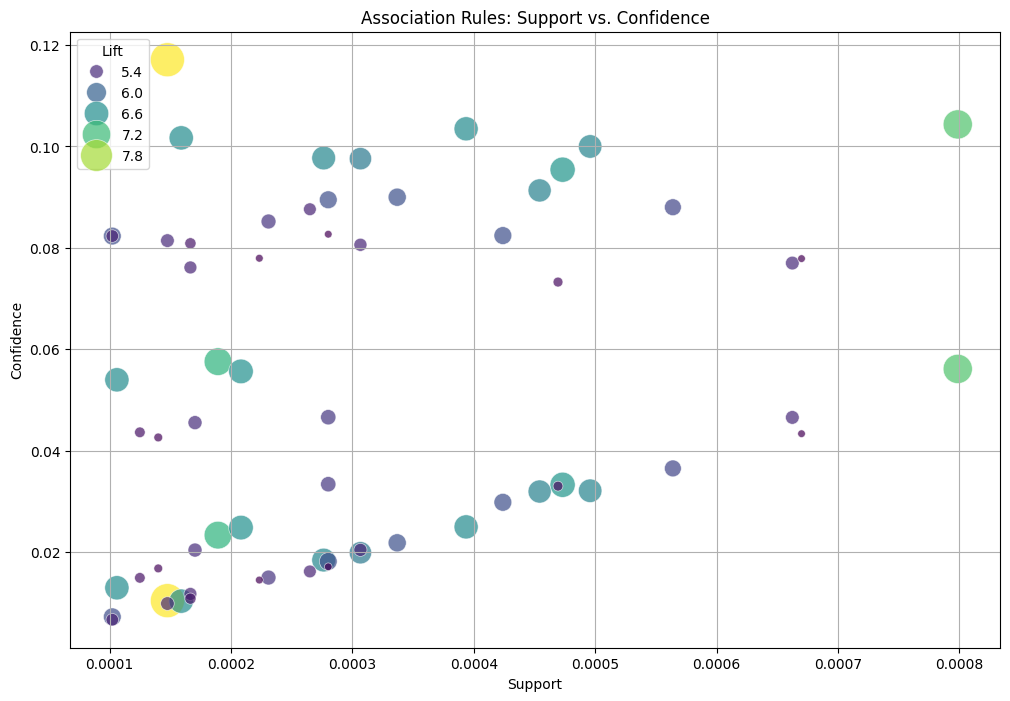

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    data=rules,
    hue="lift",
    palette="viridis",
    sizes=(30, 600),
    alpha=0.7
)
plt.title('Association Rules: Support vs. Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift')
plt.grid(True)
plt.show()

**3.2. Associations visualization**

In [20]:
def get_rules_dict(rules, dim1, dim2):
    dim_rules = rules[(rules['antecedents'].apply(lambda x: len(x) == 1 and str(list(x)[0]).startswith(f'{dim1}_'))) &
                      (rules['consequents'].apply(lambda x: len(x) == 1 and str(list(x)[0]).startswith(f'{dim2}_')))
                      ].copy()
    dim_map = defaultdict(list)
    for _, row in dim_rules.iterrows():
        ant = get_item_str(row['antecedents'])
        cons = get_item_str(row['consequents'])
        if ant and cons: dim_map[ant].append(cons)
    return dim_map

In [21]:
rules_dict = get_rules_dict(rules, "decade", "cluster")

In [22]:
def plot_rules(dim_map, dim1, dim2):
    plot_data_list = []
    for dim_1 , associated_dim_2 in dim_map.items():
        for dim_2 in associated_dim_2:
            plot_data_list.append({f'{dim1}': dim_1, f'{dim2}': dim_2})


    plot_df = pd.DataFrame(plot_data_list)

    sorted_dim1 = sorted(plot_df[f'{dim1}'].unique())
    sorted_dim2 = sorted(plot_df[f'{dim2}'].unique())

    # Create the strip plot
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        x=f'{dim1}',
        y='cluster',
        data=plot_df,
        order=sorted_dim1,
        legend=False,
        hue=f'{dim1}',
        size=10,
        marker='o',
        jitter=False,
        palette='tab20',
    )
    plt.margins(y=0.05)
    plt.title(f'{dim2} associated with each artworks {dim1}')
    plt.xlabel(f'Artwork {dim1}')
    plt.ylabel(f'Associated {dim2}')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

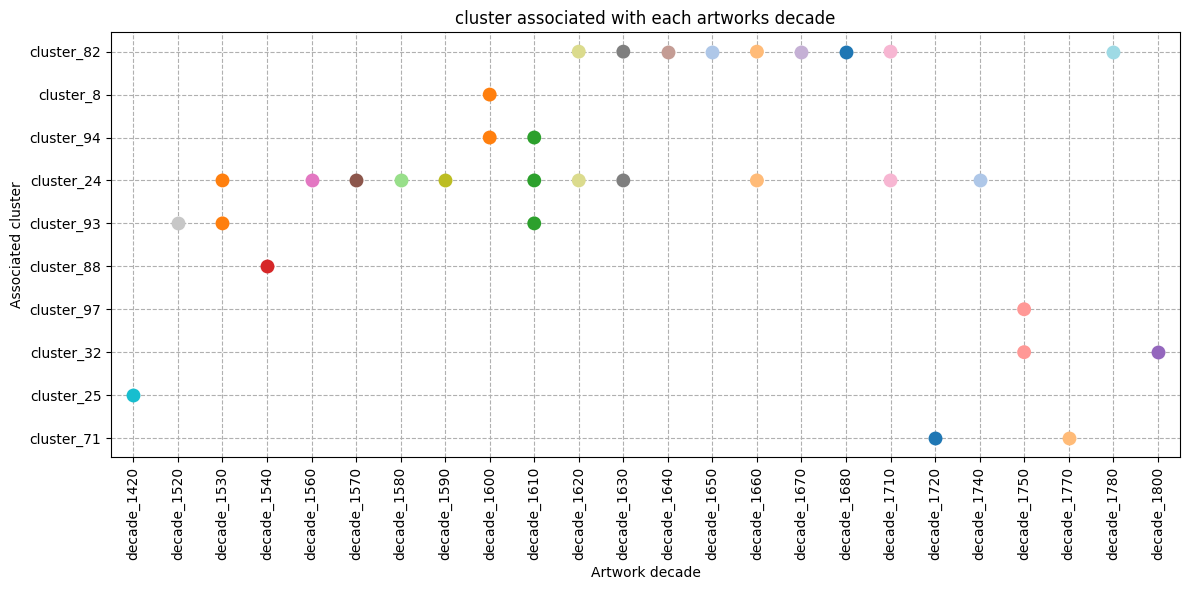

In [23]:
plot_rules(rules_dict, "decade", "cluster")

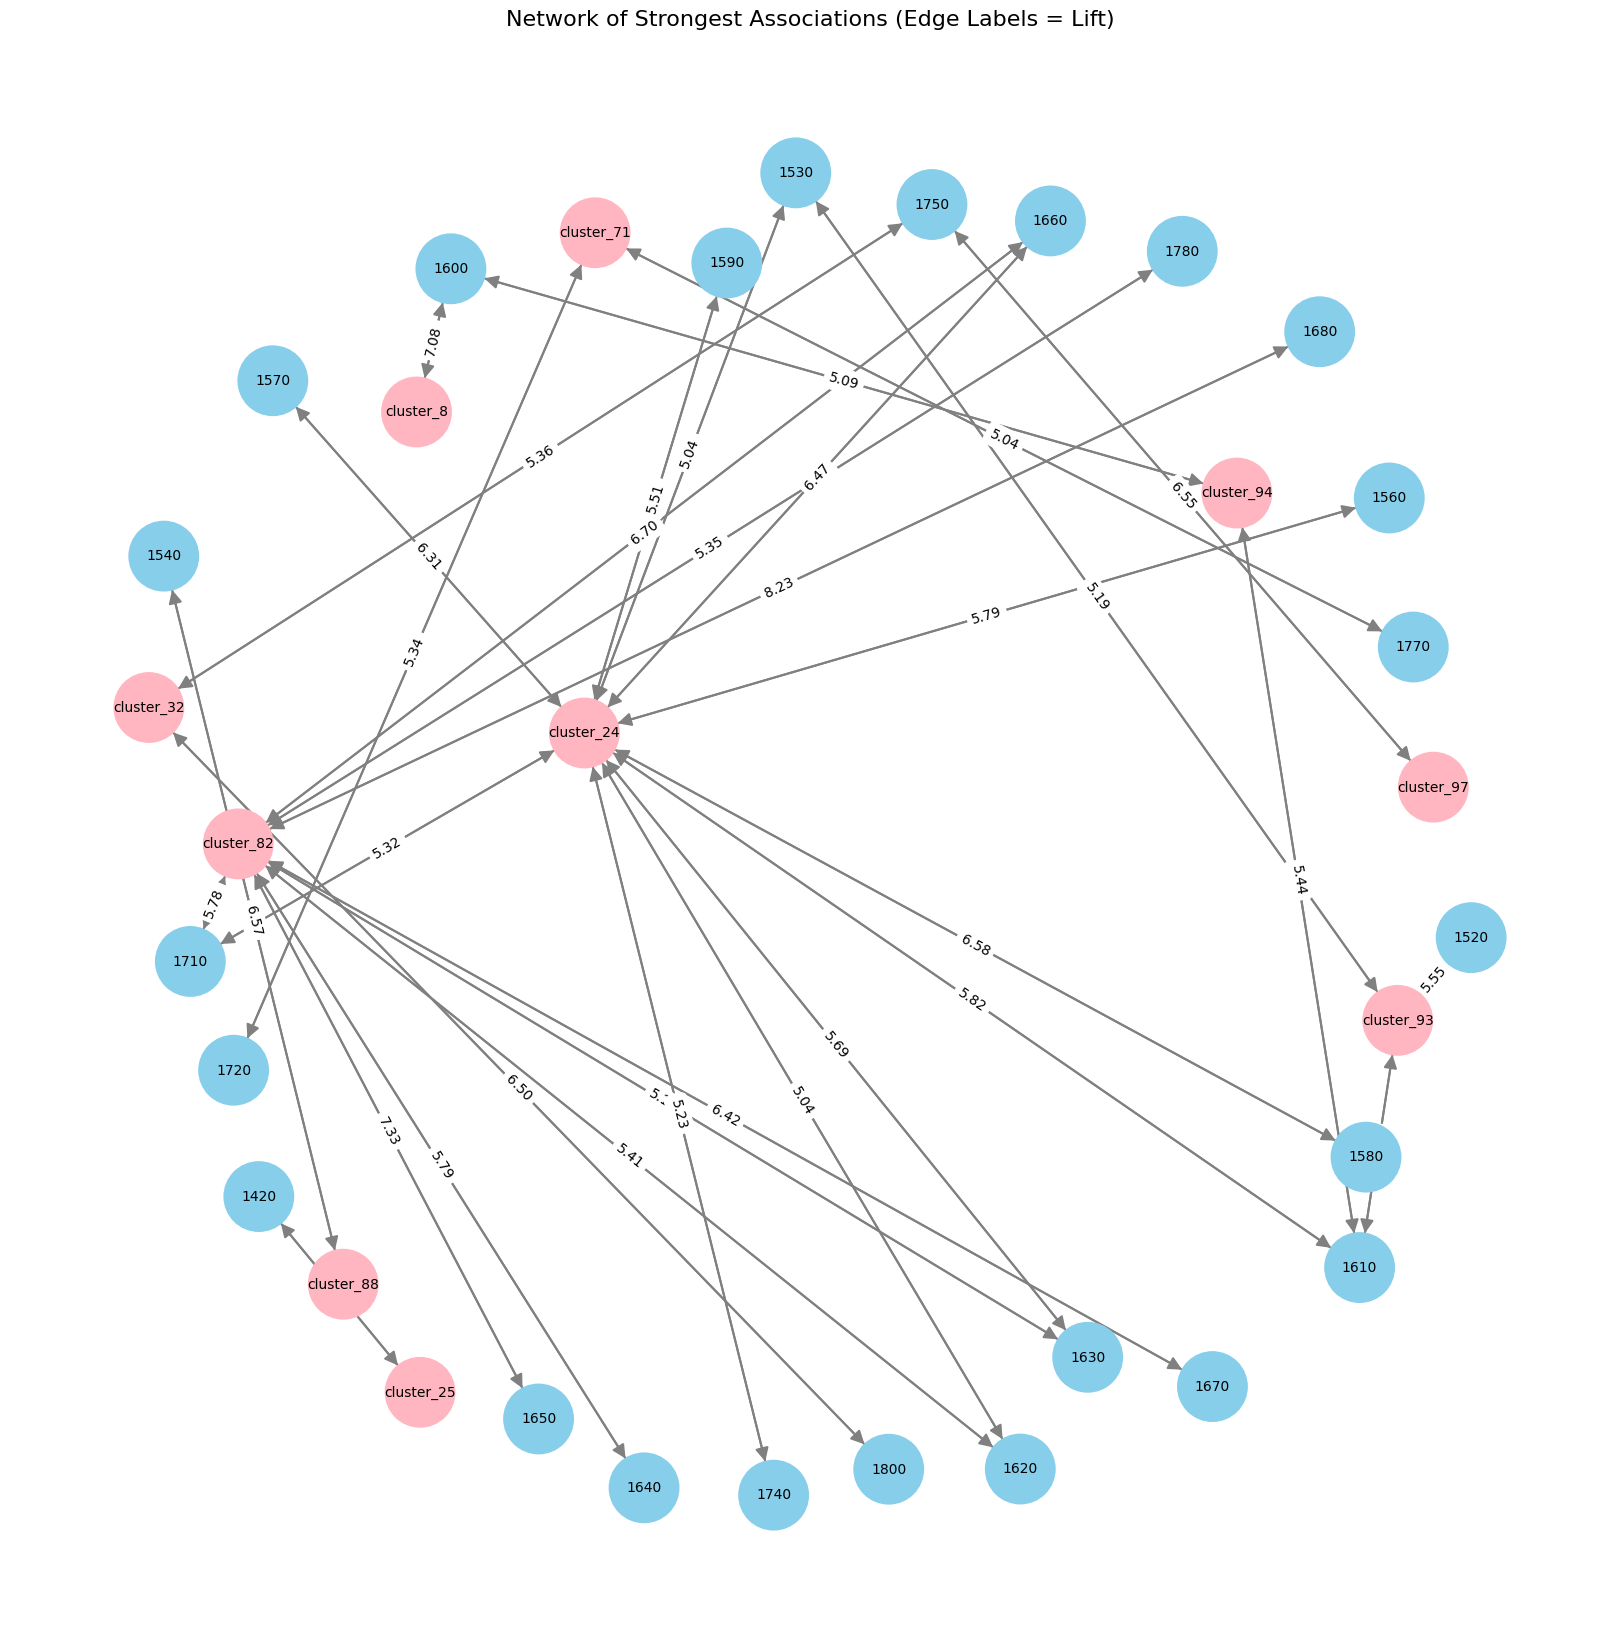

In [24]:
import networkx as nx

# --- Data Preparation ---
# Filter for simpler, stronger rules for a cleaner graph.
# This code assumes your 'antecedents' and 'consequents' are frozensets.
graph_rules = rules[
    (rules.get('antecedents', pd.Series([frozenset()]*len(rules))).apply(len) == 1) &
    (rules.get('consequents', pd.Series([frozenset()]*len(rules))).apply(len) == 1)
].copy()

# Convert frozensets to strings for labeling
# Note: You might need to adapt this if your sample data doesn't have these columns
if 'antecedents' in graph_rules.columns:
    graph_rules['antecedent_str'] = graph_rules['antecedents'].apply(lambda x: list(x)[0])
    graph_rules['consequent_str'] = graph_rules['consequents'].apply(lambda x: list(x)[0])
else: # Fallback for sample data
    graph_rules['antecedent_str'] = [f'item_{i}' for i in range(len(graph_rules))]
    graph_rules['consequent_str'] = [f'item_{i+100}' for i in range(len(graph_rules))]


# --- Plotting Code ---
plt.figure(figsize=(16, 16))
G = nx.from_pandas_edgelist(
    graph_rules,
    source='antecedent_str',
    target='consequent_str',
    edge_attr='lift',
    create_using=nx.DiGraph()
)

# Create color map based on original node names
node_colors = ['skyblue' if 'decade' in node else 'lightpink' for node in G.nodes()]

# Create a mapping to trim the '' prefix for cleaner labels
relabel_mapping = {node: node.replace('decade_', '') for node in G.nodes()}
G_relabeled = nx.relabel_nodes(G, relabel_mapping)

pos = nx.spring_layout(G_relabeled, k=2.7, iterations=50)

# Draw the relabeled graph using the original color list
nx.draw(G_relabeled, pos, with_labels=True, node_color=node_colors, node_size=2500, font_size=10, width=1.5, edge_color='gray', arrowsize=20)

# Create edge labels using the original graph G to access lift data
edge_labels = {(relabel_mapping.get(u), relabel_mapping.get(v)): f"{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G_relabeled, pos, edge_labels=edge_labels, font_color='black')

plt.title('Network of Strongest Associations (Edge Labels = Lift)', fontsize=16)
plt.show()

**3.3. Antecedents influence scores**

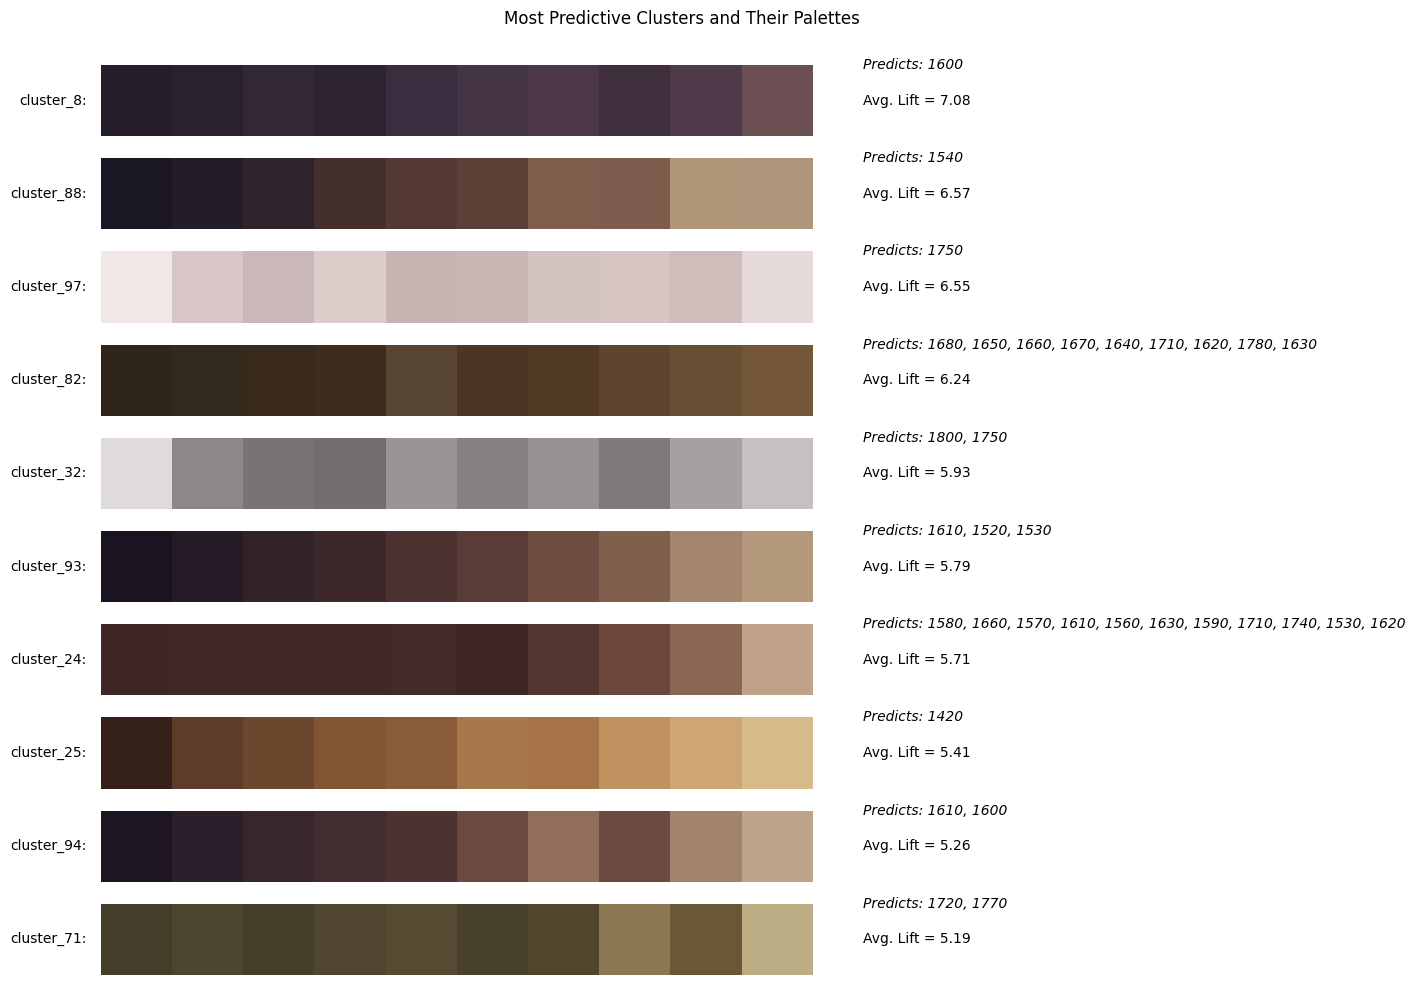

In [25]:
# Filter for rules where the antecedent is a single item starting with 'cluster_'
cluster_antecedent_rules = rules[
    (rules['antecedents'].apply(lambda x: len(x) == 1 and 'cluster_' in list(x)[0]))
].copy()
cluster_antecedent_rules['antecedent_str'] = cluster_antecedent_rules['antecedents'].apply(lambda x: list(x)[0])

# Group by the antecedent and calculate the mean lift and number of rules
influence_scores = cluster_antecedent_rules.groupby('antecedent_str')['lift'].agg(['mean', 'count']).reset_index()
influence_scores = influence_scores.rename(columns={'mean': 'average_lift', 'count': 'num_rules'})
influence_scores = influence_scores.sort_values('average_lift', ascending=False)
    
# --- Plotting Code ---
def get_rgb_from_hsv(h, s, v):
    h_normalized = h / 360.0
    return colorsys.hsv_to_rgb(np.clip(h_normalized, 0, 1), np.clip(s, 0, 1), np.clip(v, 0, 1))

# Create one figure to hold all the subplots
fig, axes = plt.subplots(
    nrows=len(influence_scores), 
    ncols=1, 
    figsize=(12, len(influence_scores))
    )
fig.suptitle('Most Predictive Clusters and Their Palettes')

for i, (idx, influence_row) in enumerate(influence_scores.iterrows()):
    ax = axes[i]
    cluster_name = influence_row['antecedent_str']
    avg_lift = influence_row['average_lift']
        
    cluster_palette_row = artwork_clusters[artwork_clusters['name'] == cluster_name]
    if cluster_palette_row.empty: continue

    # Find the top predicted decades for this cluster
    top_rules = cluster_antecedent_rules[cluster_antecedent_rules['antecedent_str'] == cluster_name].sort_values('lift', ascending=False)
    predicted = [list(c)[0].replace('decade_', '') for c in top_rules['consequents']]
    pred_str = f"Predicts: {', '.join(predicted)}"

    palette_data = []
    for j in range(0, 10):
        h = cluster_palette_row[f'{j}_H'].values[0]
        s = cluster_palette_row[f'{j}_S'].values[0]
        b = cluster_palette_row[f'{j}_B'].values[0]
        weight = cluster_palette_row[f'{j}_weight'].values[0]
        palette_data.append((h, s, b, weight))
        
    sorted_palette = sorted(palette_data, key=lambda x: x[3], reverse=True)
    rgb_palette = [get_rgb_from_hsv(c[0], c[1], c[2]) for c in sorted_palette]
        
    ax.imshow([rgb_palette])
        
    # Add text labels for the cluster name and lift
    ax.text(-0.7, 0, f"{cluster_name}:", ha='right', va='center')
    ax.text(10.2, 0, f"Avg. Lift = {avg_lift:.2f}", ha='left', va='center')
    ax.text(10.2, -0.5, pred_str, ha='left', va='center', style='italic')

    ax.axis('off')
    
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**3.4. Associated color palettes**

In [26]:
# --- Helper function to convert HSV to a plottable RGB color ---
def get_rgb_from_hsv(h, s, v):
    # Normalize hue from 0-360 range to 0-1 range for the function
    h_normalized = h / 360.0
    # Clip saturation and value to be within the valid 0-1 range
    s = np.clip(s, 0, 1)
    v = np.clip(v, 0, 1)
    return colorsys.hsv_to_rgb(h_normalized, s, v)

In [27]:
def plot_palettes(artwork_clusters, rules_dict):
    for decade, associated_clusters in rules_dict.items():

        # Create a new figure for each decade.
        # The number of rows will match the number of associated clusters.
        fig, axes = plt.subplots(
            nrows=len(associated_clusters),
            ncols=1,
            figsize=(10, max(3.0, 1.5 * len(associated_clusters)))
        )
        # Set a clean, descriptive title for the entire figure
        fig.suptitle(decade.replace('decade_', ''))

        # If a decade has only one cluster, 'axes' is not a list, so we make it one
        if len(associated_clusters) == 1:
            axes = [axes]

        # For each cluster associated with the current decade...
        for i, cluster_name in enumerate(associated_clusters):
            # Find the row in the DataFrame for this specific cluster
            cluster_row = artwork_clusters[artwork_clusters['name'] == cluster_name]

            # Extract the palette data (H, S, B, and weight) for the 10 colors
            palette_data = []
            for j in range(0, 10):
                # Read H directly instead of H_sin and H_cos
                h = cluster_row[f'{j}_H'].values[0]
                s = cluster_row[f'{j}_S'].values[0]
                b = cluster_row[f'{j}_B'].values[0]
                weight = cluster_row[f'{j}_weight'].values[0]
                palette_data.append((h, s, b, weight))

            # Sort the extracted colors by their weight in descending order
            sorted_palette = sorted(palette_data, key=lambda x: x[3], reverse=True)

            # Convert the sorted HSV values into a list of plottable RGB colors
            rgb_palette = [get_rgb_from_hsv(c[0], c[1], c[2]) for c in sorted_palette]

            # Get the current axis for plotting
            ax = axes[i]
            # Use imshow to display the list of colors as a single rectangular swatch
            ax.imshow([rgb_palette])
            # Set the title for this specific palette swatch
            ax.set_title(cluster_name, loc='left', fontsize=12)
            # Turn off the axis ticks and labels for a clean look
            ax.set_xticks([])
            ax.set_yticks([])

        # Adjust layout to prevent titles from overlapping
        plt.tight_layout()
        # Create a clean filename from the decade name and save the figure
        clean_decade_name = decade.replace('decade_', '').replace(' ', '_')
        filename = f"images/{clean_decade_name}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=150)
        print(f"Saved figure as: {filename}")
        plt.close(fig)

In [28]:
plot_palettes(artwork_clusters, rules_dict)

Saved figure as: images/1680.png
Saved figure as: images/1650.png
Saved figure as: images/1600.png
Saved figure as: images/1660.png
Saved figure as: images/1610.png
Saved figure as: images/1580.png
Saved figure as: images/1540.png
Saved figure as: images/1750.png
Saved figure as: images/1800.png
Saved figure as: images/1670.png
Saved figure as: images/1570.png
Saved figure as: images/1640.png
Saved figure as: images/1560.png
Saved figure as: images/1710.png
Saved figure as: images/1630.png
Saved figure as: images/1520.png
Saved figure as: images/1590.png
Saved figure as: images/1620.png
Saved figure as: images/1420.png
Saved figure as: images/1780.png
Saved figure as: images/1720.png
Saved figure as: images/1740.png
Saved figure as: images/1530.png
Saved figure as: images/1770.png
